![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: data management

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

### Task: 

Use Deribit's `"/public/get_tradingview_chart_data"` API endpoint to download historical price data for **"BTC-PERPETUAL"** with a resolution of $60$ minutes, reaching as far back as possible.

Hint: https://docs.deribit.com/#public-get_tradingview_chart_data

In [1]:
import requests
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, MetaData, Table, inspect, Column, DateTime, Float, String, Integer
from sqlalchemy.engine import result
from sqlalchemy.exc import NoSuchTableError

In [11]:
# Define the URL of the endpoint
url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"

end_time = int(time.time() * 1000)  # Current time in milliseconds
start_time = 0

# Define the parameters
params = {
    "instrument_name": "BTC-PERPETUAL",
    "start_timestamp": start_time,
    "end_timestamp": end_time,
    "resolution": "60"
}

# Send the GET request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the response to JSON
    print(json.dumps(data, indent=4))  # Print the data
else:
    print(f"Failed to retrieve data: {response.status_code}")

{
    "usOut": 1717256570075158,
    "usIn": 1717256570029746,
    "usDiff": 45412,
    "testnet": false,
    "result": {
        "volume": [
            344.82324307,
            307.20640534,
            846.4793496,
            816.35662585,
            351.24706426,
            329.077647,
            642.24474967,
            494.8314254,
            340.99263417,
            278.88148467,
            253.42635589,
            707.7234125,
            323.12484937,
            288.66502814,
            292.04519114,
            294.11344083,
            364.04565365,
            214.56455889,
            252.02885605,
            198.57819254,
            94.36031377,
            162.35081656,
            98.10619201,
            237.27760029,
            169.34346454,
            277.96349255,
            357.0584211,
            853.52380322,
            518.88840611,
            444.53748129,
            420.99304245,
            390.94521607,
            503.67190282,
        

### Task: 

Create a Pandas data frame called "ohlc" with the price data from above. Add the following columns:
```Python
ohlc['timestamp'] = pd.to_datetime(ohlc['ticks'], unit='ms')
ohlc['instrument_name'] = "BTC-PERPETUAL"
ohlc['resolution'] = 60
```

Save `ohlc` into a table of the same name inside a database called "07_datam.db".


In [12]:
# Use the 'data' to create a DataFrame
ohlc = pd.DataFrame()
ohlc["timestamp"] = pd.to_datetime(data['result']['ticks'], unit='ms')
ohlc["open"] = data['result']['open']
ohlc["high"] = data['result']['high']
ohlc["low"] = data['result']['low']
ohlc["close"]= data['result']['close']
ohlc["cost"] = data['result']['cost']
ohlc["volume"] = data['result']['volume']
ohlc['instrument_name'] = "BTC-PERPETUAL"
ohlc['resolution'] = 60

print(ohlc.head(5))

# Connect and write to the database
engine = create_engine('sqlite:///07_datam.db')
ohlc.to_sql("ohlc", engine, if_exists="replace", index=False)


# Testing the database
test_table = pd.read_sql("""SELECT * FROM ohlc WHERE timestamp LIKE '2024-06-01%'""", engine)


            timestamp     open     high      low    close        cost  \
0 2023-11-06 07:00:00  34897.0  34972.0  34855.5  34960.5  12040140.0   
1 2023-11-06 08:00:00  34961.0  35002.0  34876.5  35001.5  10733390.0   
2 2023-11-06 09:00:00  35002.0  35154.0  34977.0  35148.5  29694700.0   
3 2023-11-06 10:00:00  35148.5  35312.0  35129.0  35203.0  28742510.0   
4 2023-11-06 11:00:00  35197.0  35273.5  35129.0  35272.5  12366230.0   

       volume instrument_name  resolution  
0  344.823243   BTC-PERPETUAL          60  
1  307.206405   BTC-PERPETUAL          60  
2  846.479350   BTC-PERPETUAL          60  
3  816.356626   BTC-PERPETUAL          60  
4  351.247064   BTC-PERPETUAL          60  


### Task: 

Create a Python `class DataHandler` that connects to 07_datam.db. The class should have functions that:
* download and save,
* select and return, and
* display data as a plot (e.g. the last price over time).

Deleted table 'ohlc' successfully.
Created a new Table 'ohcl' and wrote Data to the database successfully.


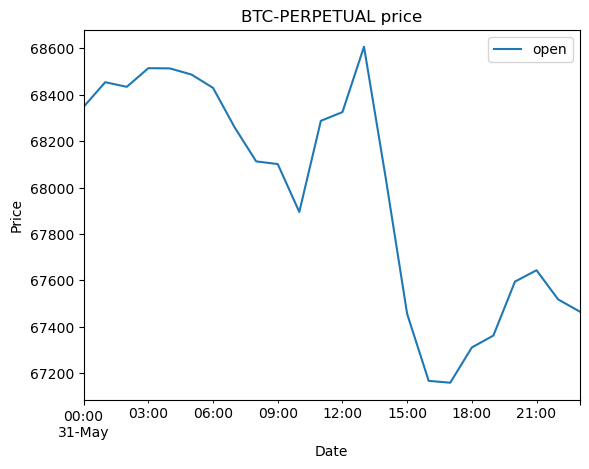

Deleted table 'ohlc' successfully.
Ein Fehler ist aufgetreten: (sqlite3.OperationalError) no such table: ohlc
[SQL: 
            SELECT * FROM ohlc
            WHERE timestamp BETWEEN '2024-05-31' AND '2024-06-01'
            AND instrument_name = 'BTC-PERPETUAL'
            AND resolution = '60'
            ]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Created a new Table 'ohcl' and wrote Data to the database successfully.


In [13]:
class DataHandler:
    def __init__(self, db_path):
        self.engine = create_engine(f'sqlite:///{db_path}')
        self.metadata = MetaData()
        self.inspector = inspect(self.engine)
    
    def export_data(self):
        data_df = pd.read_sql("SELECT * FROM ohlc", self.engine)
        data_df.to_json("07_data.json", orient="records")

    def new_data(self, instrument_name = "BTC-PERPETUAL", resolution = 60):
        url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"
        end_time = int(time.time() * 1000)  # Current time in milliseconds
        if 'ohlc' in self.inspector.get_table_names():
            start_time = pd.read_sql("SELECT MAX(timestamp) FROM ohlc", self.engine).values[0][0]
            new_table = False
        else: 
            start_time = 0
            new_table = True

        # Define the parameters
        params = {
            "instrument_name": instrument_name,
            "start_timestamp": start_time,
            "end_timestamp": end_time,
            "resolution": resolution
        }
        
        # Send the GET request
        response = requests.get(url, params=params)

        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()  # Parse the response to JSON
            # Write data to the database
            ohlc = pd.DataFrame()
            ohlc["timestamp"] = pd.to_datetime(data['result']['ticks'], unit='ms')
            ohlc["open"] = data['result']['open']
            ohlc["high"] = data['result']['high']
            ohlc["low"] = data['result']['low']
            ohlc["close"]= data['result']['close']
            ohlc["cost"] = data['result']['cost']
            ohlc["volume"] = data['result']['volume']
            ohlc['instrument_name'] = instrument_name
            ohlc['resolution'] = resolution
            if new_table == True:
                ohlc.to_sql("ohlc", self.engine, if_exists="replace", index=False)
                print("Created a new Table 'ohcl' and wrote Data to the database successfully.")

            else:
                ohlc.to_sql("ohlc", self.engine, if_exists="append", index=False)
                print("Appended the new data to the existing table successfully.")
            
            
        else:
            if new_table == True:
                print(f"Failed to retrieve data: {response.status_code}\n The data could not be written to the database.")
            else:
                print(f"Failed to retrieve data: {response.status_code}\n Maybe there is no new data available.")


    def get_data(self, start_date, end_date, instrument_name = "BTC-PERPETUAL", resolution = 60):
        try:
            query = f"""
            SELECT * FROM ohlc
            WHERE timestamp BETWEEN '{start_date}' AND '{end_date}'
            AND instrument_name = '{instrument_name}'
            AND resolution = '{resolution}'
            """
            return pd.read_sql(query, self.engine)

        # Exception handling
        except NoSuchTableError:
            print("Die Tabelle 'ohlc' existiert nicht.")
        except Exception as e:
            print(f"Ein Fehler ist aufgetreten: {e}")

    
    def plot_data(self, start_date, end_date, instrument_name = "BTC-PERPETUAL", price_type="close"):
        try:
            data = self.get_data(start_date, end_date, instrument_name)
            data["timestamp"] = pd.to_datetime(data["timestamp"])
            data.plot(x="timestamp", y=price_type, title=f"{instrument_name} price", xlabel="Date", ylabel="Price")
            plt.show()
        # Exception handling
        except Exception as e:
            print(f"Ein Fehler ist aufgetreten: {e}")

        
    # Just for testing purposes
    def delete_data(self, table_name):
        try:
            # table to be deleted
            del_table = Table('ohlc', self.metadata, autoload_with=self.engine, extend_existing=True)
            # Delete the table
            del_table.drop(self.engine)
            print("Deleted table 'ohlc' successfully.")
        # Exception handling
        except NoSuchTableError:
            print("The table 'ohlc' does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

# Testing the DataHandler class
TestDataHandler = DataHandler("07_datam.db")
# Deleting the table
TestDataHandler.delete_data("ohlc")
# Getting new data from the API
TestDataHandler.new_data()
# Viewing the data
TestDataHandler.get_data("2024-05-31", "2024-06-01", "BTC-PERPETUAL")
# Plotting the data
TestDataHandler.plot_data("2024-05-31", "2024-06-01", "BTC-PERPETUAL", "open")
# Deleting the table
TestDataHandler.delete_data("ohcl")
# Throw an error because the table does not exist
TestDataHandler.get_data("2024-05-31", "2024-06-01", "BTC-PERPETUAL")
# Getting new data from the API
TestDataHandler.new_data()
# Viewing the data
TestDataHandler.get_data("2024-05-31", "2024-06-01", "BTC-PERPETUAL").head(5)
# Exporting the data to a JSON file
TestDataHandler.export_data()
